In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy
import pandas as pd
import seaborn as sns

import cv2
import skvideo.io
import imageio
import pytube

import os
import time
import csv
import re
import humanize
from tqdm import tqdm

from skimage.measure import compare_mse, compare_ssim, compare_nrmse
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import hamming
from imageai.Detection import ObjectDetection

Using TensorFlow backend.


In [24]:
import multiprocessing as mp

In [4]:
from PIL import Image, ImageChops

In [25]:
import platform

def print_sysinfo():

    print('\nPython version  :', platform.python_version())
    print('compiler        :', platform.python_compiler())

    print('\nsystem     :', platform.system())
    print('release    :', platform.release())
    print('machine    :', platform.machine())
    print('processor  :', platform.processor())
    print('CPU count  :', mp.cpu_count())
    print('interpreter:', platform.architecture()[0])
    print('\n\n')

print_sysinfo()


Python version  : 3.6.5
compiler        : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)

system     : Linux
release    : 3.10.0-862.3.2.el7.x86_64
machine    : x86_64
processor  : x86_64
CPU count  : 16
interpreter: 64bit





# Data

In [3]:
def folder_size(path='.'):
    total = 0
    for entry in os.scandir(path):
        if entry.is_file():
            total += entry.stat().st_size
        elif entry.is_dir():
            total += folder_size(entry.path)
    return humanize.naturalsize(total)

In [4]:
def video_to_image(video_loc, img_folder, dataset_type):
    raw = {}
    
    tqdm.write('Reading in video file ...')
    cap = skvideo.io.vread(video_loc)
    
    tqdm.write('Constructing dataset ...')
    for idx, frame in enumerate(tqdm(cap)):
        img_path = os.path.join(img_folder, str(idx)+'.jpg')
        raw[idx] = [img_path, idx]
        skvideo.io.vwrite(img_path, frame)
    
    raw_df = pd.DataFrame.from_dict(raw, orient='index')
    raw_df.columns = ['img_path', 'img_index']
    
    tqdm.write('Writing raw to csv')
    raw_df.to_csv(os.path.join(data_path, dataset_type+'_raw.csv'), index=False)
    
    return 'Done'

In [5]:
def video_to_image2(video_loc, img_folder, dataset_type, start_idx=0, end_idx=100000, img_quality=90):
    raw = {}
    
    cap = cv2.VideoCapture(video_loc)
    idx = 0
    ret = True
    while ret:
        ret, frame = cap.read()
        if idx > start_idx:
            img_path = os.path.join(img_folder, str(idx)+'.jpg')
            raw[idx] = [img_path, idx]
            frame = cv2.flip(frame, -1)
            cv2.imwrite(img_path, frame, [cv2.IMWRITE_JPEG_QUALITY, img_quality])
        idx += 1
        if idx == end_idx:
            break
    cap.release()
    
    print('Done with %d frames' % (end_idx - start_idx - 1))
    print('Start index: ', start_idx)
    print('End index: ', end_idx)
    
    raw_df = pd.DataFrame.from_dict(raw, orient='index')
    raw_df.columns = ['img_path', 'img_index']
    raw_df.to_csv(os.path.join(data_path, dataset_type+'_raw.csv'), index=False)

In [3]:
save_path = '/home/idies/workspace/Storage/Cong/persistent/video/data'
data_path = '/home/idies/workspace/Storage/Cong/persistent/video/data'
result_path = '/home/idies/workspace/Storage/Cong/persistent/video/result'

In [4]:
train_video = os.path.join(data_path, 'LapTimer-20180624-091108.mp4')
train_imgs = os.path.join(data_path, 'imgs091108')

In [83]:
video_to_image2(train_video, train_imgs, 'train091108', 3450, 27970, 30)

Done with 24519 frames.
Start index:  3450
End index:  27970
Writing raw to csv


In [29]:
train_df = pd.read_csv(os.path.join(data_path, 'train091108_raw.csv'))
train_df.shape

(24519, 2)

Shape:  (1080, 1920, 3)


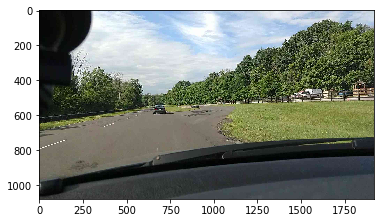

In [33]:
img = imread(train_df['img_path'][0])
print('Shape: ', img.shape)
imshow(img);

In [38]:
train_video = os.path.join(data_path, 'LapTimer-20180624-153240.mp4')
train_imgs = os.path.join(data_path, 'imgs153240')

In [39]:
video_to_image2(train_video, train_imgs, 'train153240', 3000, 32760, 30)

Done with 29759 frames
Start index:  3000
End index:  32760


In [40]:
train_df = pd.read_csv(os.path.join(data_path, 'train153240_raw.csv'))
train_df.shape

(29759, 2)

Shape:  (1080, 1920, 3)


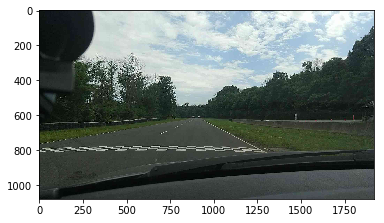

In [42]:
img = imread(train_df['img_path'][0])
print('Shape: ', img.shape)
imshow(img);

In [107]:
def laptime_video(start, end, fps):
    return (end - start) / fps

In [108]:
laptime_video(3522, 6282, 29.93930396046777)

92.18651187229797

In [109]:
laptime_video(6282, 9040, 29.93930396046777)

92.11971005210066

In [110]:
laptime_video(9040, 11757, 29.93930396046777)

90.75027273805566

In [111]:
laptime_video(11757, 14453, 29.93930396046777)

90.04885362598382

In [112]:
laptime_video(14453, 17138, 29.93930396046777)

89.68144361489857

In [113]:
laptime_video(17138, 19830, 29.93930396046777)

89.91524998558918

In [114]:
laptime_video(19830, 22497, 29.93930396046777)

89.08022723312271

In [115]:
laptime_video(22497, 25194, 29.93930396046777)

90.08225453608247

In [116]:
laptime_video(25194, 27876, 29.93930396046777)

89.5812408846026

# Preprocessing

In [4]:
def image_crop(h1, h2, l1, l2, original):
    return original[h1:h2, l1:l2, :]

In [5]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [5]:
def add_mask(img, coordinates):
    mask = np.zeros(img.shape, dtype = 'uint8')
    
    for coord in coordinates:
        cv2.rectangle(mask, coord[0], coord[1], (255, 255, 255), -1);
        
    maskedImg = cv2.bitwise_and(img, mask)
    return maskedImg

In [6]:
def detect_object(img, model='resnet50_coco_best_v2.0.1.h5', minimum_prob=80):
    detector = ObjectDetection()
    detector.setModelTypeAsRetinaNet()
    detector.setModelPath(os.path.join('/home/idies/workspace/Storage/Cong/persistent/video', model))
    detector.loadModel()
    detections = detector.detectObjectsFromImage(input_image=img, input_type='array', minimum_percentage_probability=minimum_prob)
    return detections

In [14]:
bright_factor = 0.2 + np.random.uniform()
bright_factor

1.0426016233980548

In [17]:
train_df = pd.read_csv(os.path.join(data_path, 'train091108_raw.csv'))
train_df.shape

(24519, 2)

Shape:  (1080, 1920, 3)
Frame:  19762


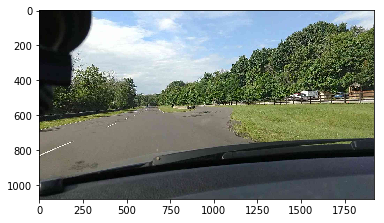

In [88]:
idx = 16311
img = imread(train_df['img_path'][idx])
print('Shape: ', img.shape)
print('Frame: ', train_df['img_index'][idx])
imshow(img);

In [89]:
imsave(os.path.join(save_path, str(train_df['img_index'][idx])+'.jpg'), img);

Shape:  (1080, 1920, 3)
Frame:  22430


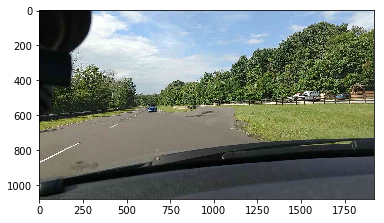

In [90]:
similar_idx = int(idx + 89.1370 * 29.93930396046777)
similar = imread(train_df['img_path'][similar_idx])
print('Shape: ', similar.shape)
print('Frame: ', train_df['img_index'][similar_idx])
imshow(similar);

In [91]:
imsave(os.path.join(save_path, str(train_df['img_index'][idx])+'_MSE.jpg'), similar);

Shape:  (1080, 1920, 3)
Frame:  22442


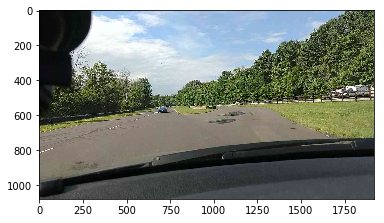

In [92]:
similar_idx = int(idx + 89.0635 * 29.93930396046777) + 14
similar = imread(train_df['img_path'][similar_idx])
print('Shape: ', similar.shape)
print('Frame: ', train_df['img_index'][similar_idx])
imshow(similar);

In [93]:
imsave(os.path.join(save_path, str(train_df['img_index'][idx])+'_ORB.jpg'), similar);

Shape:  (1080, 1920, 3)
Frame:  22427


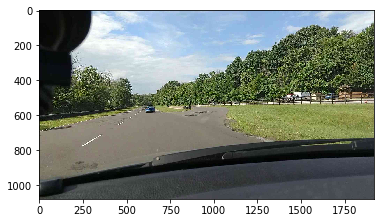

In [95]:
similar_idx = int(idx + 89.2015 * 29.93930396046777) - 5
similar = imread(train_df['img_path'][similar_idx])
print('Shape: ', similar.shape)
print('Frame: ', train_df['img_index'][similar_idx])
imshow(similar);

In [96]:
imsave(os.path.join(save_path, str(train_df['img_index'][idx])+'_pHash.jpg'), similar);

(1080, 1920, 3)


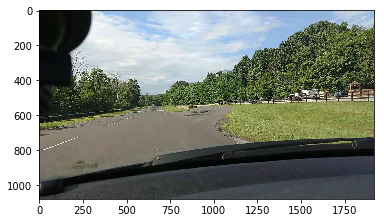

In [73]:
img = imread('./data/8970.jpg')
print(img.shape)
imshow(img);

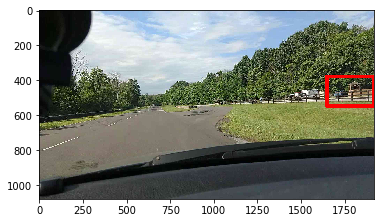

In [74]:
cv2.rectangle(img, (1650,380), (1920,550), (255,0,0), 20);
imshow(img);

In [75]:
imsave('./data/8970_compare.jpg', img)

(1080, 1920, 3)


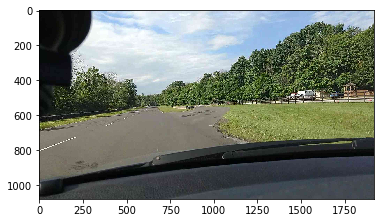

In [79]:
img = imread('./data/8970_MSE.jpg')
print(img.shape)
imshow(img);

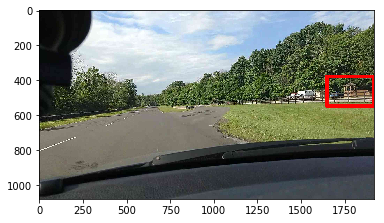

In [80]:
cv2.rectangle(img, (1650,380), (1920,550), (255,0,0), 20);
imshow(img);

In [81]:
imsave('./data/8970_compare_MSE.jpg', img)

(1080, 1920, 3)


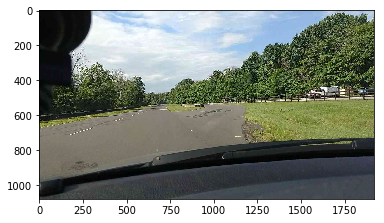

In [82]:
img = imread('./data/8970_ORB.jpg')
print(img.shape)
imshow(img);

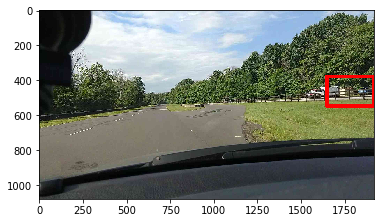

In [83]:
cv2.rectangle(img, (1650,380), (1920,550), (255,0,0), 20);
imshow(img);

In [84]:
imsave('./data/8970_compare_ORB.jpg', img)

(1080, 1920, 3)


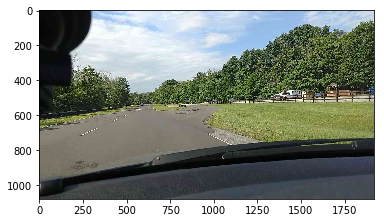

In [85]:
img = imread('./data/8970_pHash.jpg')
print(img.shape)
imshow(img);

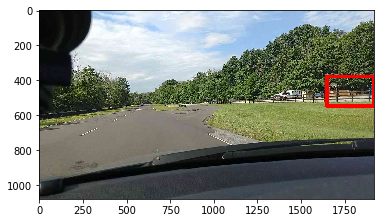

In [86]:
cv2.rectangle(img, (1650,380), (1920,550), (255,0,0), 20);
imshow(img);

In [87]:
imsave('./data/8970_compare_pHash.jpg', img)

Shape:  (1080, 1920, 3)
Frame:  4451


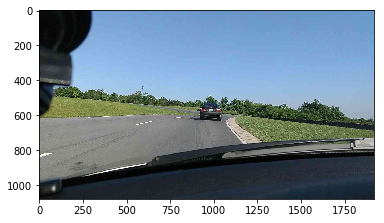

In [40]:
idx = 1000
img = imread(train_df['img_path'][idx])
print('Shape: ', img.shape)
print('Frame: ', train_df['img_index'][idx])
imshow(img);

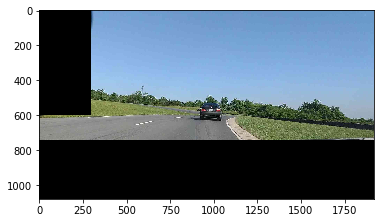

In [19]:
coords = [[(0, 600), (1920, 740)], [(300, 0), (1920, 740)]]
masked = add_mask(img, coords)
imshow(masked);

In [77]:
#imsave(os.path.join(save_path, str(train_df['img_index'][idx])+'_masked.jpg'), masked);

In [41]:
detections = detect_object(img)
detections

[{'name': 'car',
  'percentage_probability': 92.4035131931305,
  'box_points': array([ 920,  530, 1051,  635])}]

In [26]:
carcoords = []

for detection in detections:
    if detection.get('name') == 'car':
        temp = detection.get('box_points')
        carcoords.append(temp)

carcoords

[]

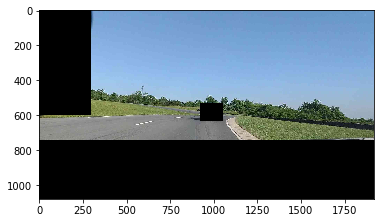

In [27]:
for carcoord in carcoords:
    cv2.rectangle(masked,(carcoord[0],carcoord[1]),(carcoord[2],carcoord[3]),(0,0,0),-1);
    
imshow(masked);

In [8]:
train_df = pd.read_csv(os.path.join(data_path, 'train153240_raw.csv'))
train_df.shape

(29759, 2)

Shape:  (1080, 1920, 3)


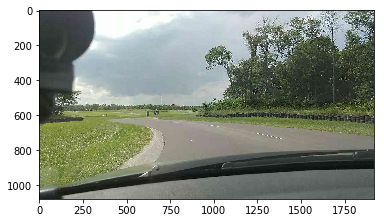

In [12]:
img = imread(train_df['img_path'][6000])
print('Shape: ', img.shape)
imshow(img);

Shape:  (410, 1670, 3)


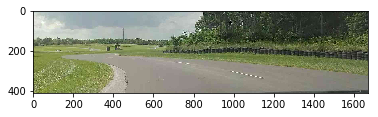

In [13]:
img1 = image_crop(400, 810, 250, 1920, img)
print('Shape: ', img1.shape)
imshow(img1);

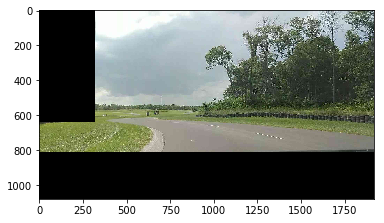

In [14]:
coords = [[(0, 640), (1920, 810)], [(320, 0), (1920, 810)]]
masked = add_mask(img, coords)
imshow(masked);

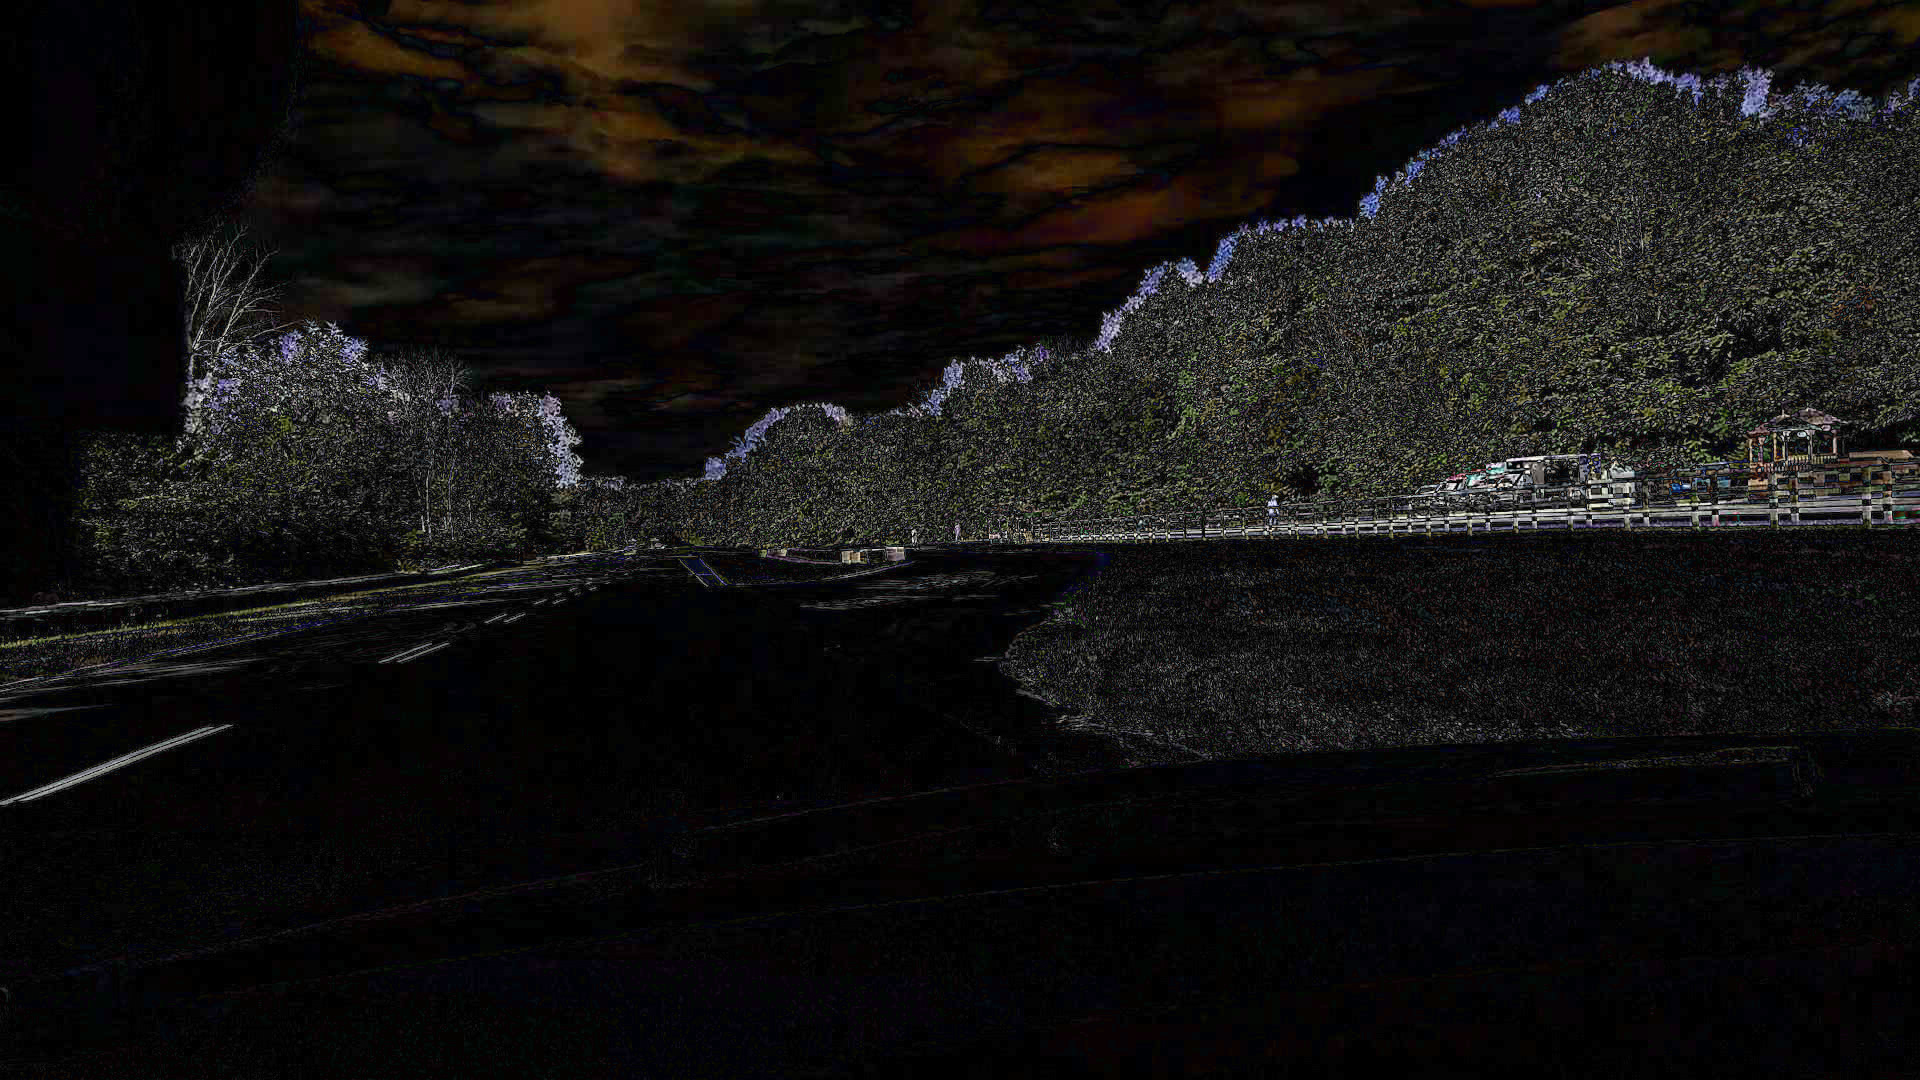

In [5]:
path_one = './data/8970.jpg'
path_two = './data/8970_MSE.jpg'
image_one = Image.open(path_one)
image_two = Image.open(path_two)
diff = ImageChops.difference(image_one, image_two)
diff

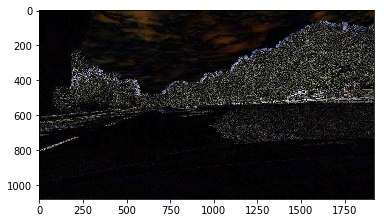

In [21]:
img1 = imread('./data/8970.jpg')
img2 = imread('./data/8970_MSE.jpg')
diff = cv2.absdiff(img1, img2)
imshow(diff);

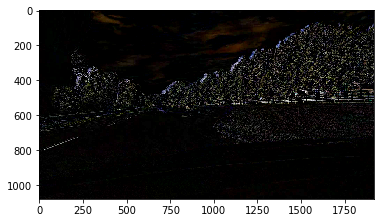

In [18]:
img1 = imread('./data/8970.jpg')
img2 = imread('./data/8970_MSE.jpg')
diff = cv2.subtract(img1, img2)
imshow(diff);
imsave('./data/8970_diff_MSE.jpg', diff);

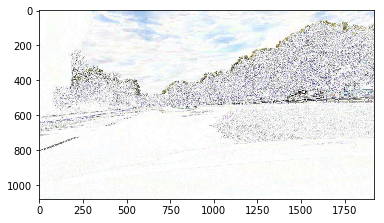

In [17]:
img1 = imread('./data/8970.jpg')
img2 = imread('./data/8970_MSE.jpg')
diff = cv2.absdiff(img1, img2)
imshow(255 - diff);
imsave('./data/8970_diff_flip_MSE.jpg', 255 - diff);

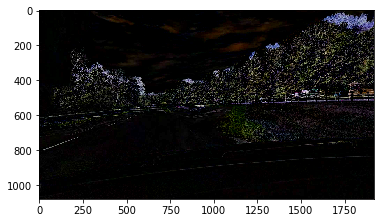

In [19]:
img1 = imread('./data/8970.jpg')
img2 = imread('./data/8970_ORB.jpg')
diff = cv2.subtract(img1, img2)
imshow(diff);
imsave('./data/8970_diff_ORB.jpg', diff);

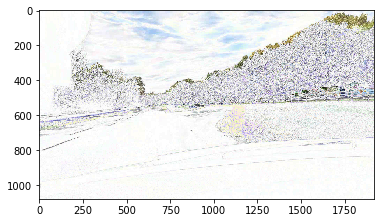

In [18]:
img1 = imread('./data/8970.jpg')
img2 = imread('./data/8970_ORB.jpg')
diff = cv2.absdiff(img1, img2)
imshow(255 - diff);
imsave('./data/8970_diff_flip_ORB.jpg', 255 - diff);

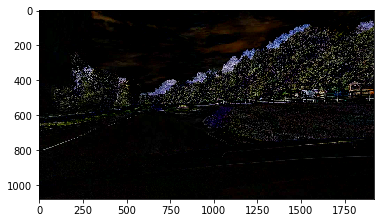

In [20]:
img1 = imread('./data/8970.jpg')
img2 = imread('./data/8970_pHash.jpg')
diff = cv2.subtract(img1, img2)
imshow(diff);
imsave('./data/8970_diff_pHash.jpg', diff);

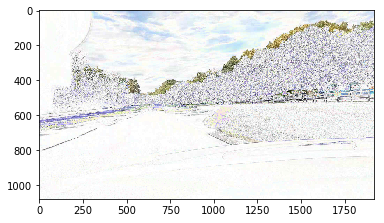

In [19]:
img1 = imread('./data/8970.jpg')
img2 = imread('./data/8970_pHash.jpg')
diff = cv2.absdiff(img1, img2)
imshow(255 - diff);
imsave('./data/8970_diff_flip_pHash.jpg', 255 - diff);

In [34]:
img1 = imread('./data/8970.jpg')
img2 = imread('./data/8970_MSE.jpg')
gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
(score, diff) = compare_ssim(gray1, gray2, full=True)
diff = (diff * 255).astype('uint8')
print('SSIM: {}'.format(score))

SSIM: 0.5871527442816653


In [35]:
thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1]

In [36]:
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(img1, (x, y), (x + w, y + h), (0, 0, 255), 2);
    cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 2);

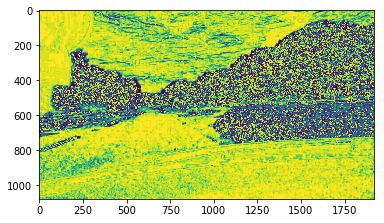

In [39]:
imshow(diff);

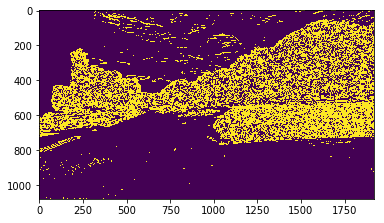

In [40]:
imshow(thresh);

In [6]:
def image_diff_heatmap(img1, img2, positive=True, palette='Spectral'):
    # Calculate the absolute difference on each channel separately
    error_r = np.fabs(np.subtract(img2[:,:,0], img1[:,:,0]))
    error_g = np.fabs(np.subtract(img2[:,:,1], img1[:,:,1]))
    error_b = np.fabs(np.subtract(img2[:,:,2], img1[:,:,2]))
    
    # Calculate the maximum error for each pixel
    lum_img = np.maximum(np.maximum(error_r, error_g), error_b)
    
    if positive is False:
        lum_img = np.negative(lum_img)
    
    imshow(lum_img.astype(uint8));
    set_cmap(palette);
    colorbar();
    axis('off');

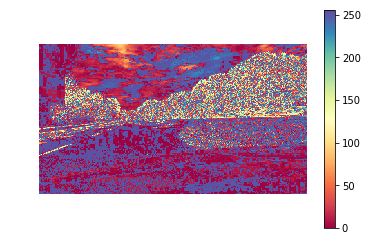

In [7]:
img1 = imread('./data/8970.jpg')
img2 = imread('./data/8970_MSE.jpg')
image_diff_heatmap(img1, img2)

In [98]:
files = os.listdir('./data/carcoords')
allcarcoords = {}

In [99]:
for file in files:
    if len(re.findall('.npy', file)) > 0:
        temp = np.load(os.path.join('./data/carcoords', file))
        for i in range(len(temp)):
            allcarcoords.update(temp[i])

In [100]:
allcarcoords = dict(sorted(allcarcoords.items()))

In [103]:
np.save('./data/carcoords/allcarcoords.npy', allcarcoords)

In [104]:
train_df = pd.read_csv(os.path.join(data_path, 'train153240_raw.csv'))
train_df.shape

(29759, 2)

Shape:  (1080, 1920, 3)
Frame:  3001


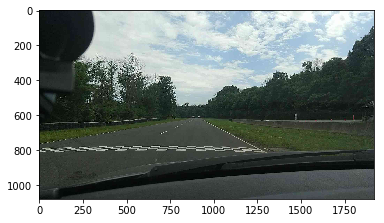

In [105]:
idx = 0
img = imread(train_df['img_path'][idx])
print('Shape: ', img.shape)
print('Frame: ', train_df['img_index'][idx])
imshow(img);

In [106]:
imsave(os.path.join(save_path, str(train_df['img_index'][idx])+'.jpg'), img);

# FPS

In [7]:
def get_FPS(video_loc):
    video = cv2.VideoCapture(video_loc)
    fps = video.get(cv2.CAP_PROP_FPS)
    return fps

In [9]:
get_FPS(train_video)

29.93930396046777

In [58]:
video = cv2.VideoCapture(train_video)
video.get(cv2.CAP_PROP_FRAME_COUNT)

30070.0

In [74]:
(30070 - 3450 - 2100) * 180 / 1024 / 1024

4.209136962890625

In [20]:
get_FPS(train_video)

29.93943500598125

In [21]:
video = cv2.VideoCapture(train_video)
video.get(cv2.CAP_PROP_FRAME_COUNT)

36523.0

In [37]:
(36523 - 3000 - 3763) * 100 / 1024 / 1024

2.838134765625

# Image Similarity

In [ ]:
def compare_wmse(img1, img2):
    float_type = np.result_type(im1.dtype, im2.dtype, np.float32)
    img1 = np.asarray(img1, dtype=float_type)
    img2 = np.asarray(img2, dtype=float_type)
    
    

In [10]:
def get_histogram(img):
    h, w = img.shape
    hist = [0.0] * 256
    for i in range(h):
        for j in range(w):
            hist[img[i, j]] += 1
    return np.array(hist) / (h * w)

In [11]:
def normalize_exposure(img):
    '''
    Normalize the exposure of an image.
    '''
    img = img.astype(int)
    hist = get_histogram(img)
    # get the sum of vals accumulated by each position in hist
    cdf = np.array([sum(hist[:i+1]) for i in range(len(hist))])
    # determine the normalization values for each unit of the cdf
    sk = np.uint8(255 * cdf)
    # normalize each position in the output image
    h, w = img.shape
    normalized = np.zeros_like(img)
    for i in range(0, h):
        for j in range(0, w):
            normalized[i, j] = sk[img[i, j]]
    return normalized.astype(int)

In [12]:
def compare_emd(img1, img2):
    img1 = normalize_exposure(img1)
    img2 = normalize_exposure(img2)
    return wasserstein_distance(get_histogram(img1), get_histogram(img2))

In [8]:
def compare_orb(img1, img2, threshold):
    orb = cv2.ORB_create()
    kp_1, desc_1 = orb.detectAndCompute(img1, None)
    kp_2, desc_2 = orb.detectAndCompute(img2, None)
    if desc_1 is None or desc_2 is None:
        return 0
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(desc_1, desc_2)
    if len(matches) == 0:
        return 0
    similar = [i for i in matches if i.distance < threshold]
    return len(similar) / len(matches)

In [14]:
def dhash(img, hashSize=8):
    # resize the input image, adding a single column (row) so we can compute the gradient
    resized_col = cv2.resize(img, (hashSize+1,hashSize))
    resized_row = cv2.resize(img, (hashSize,hashSize+1))
 
    # compute the (relative) gradient between adjacent pixels
    diff_col = resized_col[:,1:] > resized_col[:,:-1]
    diff_row = resized_row[1:,:] > resized_row[:-1,:]

    # convert the difference image to a hash
    return sum([2**i for (i, v) in enumerate(np.append(diff_col.flatten(), diff_row.flatten())) if v])

In [15]:
def compare_dhash(img1, img2, hashSize=8):
    h1 = [int(d) for d in str(int(dhash(img1)))]
    h2 = [int(d) for d in str(int(dhash(img2)))]
    
    if len(h1) == len(h2):
        dHash = hamming(h1, h2)
    else:
        dHash = 1
    return dHash

In [9]:
def compare_phash(img1, img2):
    phash = cv2.img_hash_PHash.create()
    return phash.compare(phash.compute(img1), phash.compute(img2))

In [56]:
def get_similar_image(image_df, method, ascending, idx, start, end, coords):
    results_dict = {}
            
    for i in range(start, min(end, image_df.shape[0])):
        
        img = imread(image_df['img_path'][idx])
        
        #i = i - image_df['img_index'][0]
        temp_img = imread(image_df['img_path'][i])
        
        if method == 'EMD' or method == 'ORB' or method == 'dHash':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            temp_img = cv2.cvtColor(temp_img, cv2.COLOR_RGB2GRAY)
        
        #img = image_crop(h1, h2, l1, l2, img)
        img = add_mask(img, coords)
        #temp_img = image_crop(h1, h2, l1, l2, temp_img)
        temp_img = add_mask(temp_img, coords)
        
        detections = allcarcoords[idx][2]
        #detections = detect_object(img)
        carcoords = []
        for detection in detections:
            if detection.get('name') == 'car':
                temp = detection.get('box_points')
                carcoords.append(temp)
        
        tempdetections = allcarcoords[i][2]
        #tempdetections = detect_object(temp_img)
        for detection in tempdetections:
            if detection.get('name') == 'car':
                temp = detection.get('box_points')
                carcoords.append(temp)
        
        for carcoord in carcoords:
            cv2.rectangle(img,(carcoord[0],carcoord[1]),(carcoord[2],carcoord[3]),(0,0,0),-1);
            cv2.rectangle(temp_img,(carcoord[0],carcoord[1]),(carcoord[2],carcoord[3]),(0,0,0),-1);
        
        if method == 'MSE':
            results_dict[i] = [image_df['img_path'][i], image_df['img_index'][i], compare_mse(img, temp_img)]
        elif method == 'EMD':
            results_dict[i] = [image_df['img_path'][i], image_df['img_index'][i], compare_emd(img, temp_img)]
        elif method == 'ORB':
            results_dict[i] = [image_df['img_path'][i], image_df['img_index'][i], compare_orb(img, temp_img, threshold)]
        elif method == 'dHash':
            results_dict[i] = [image_df['img_path'][i], image_df['img_index'][i], compare_dhash(img, temp_img)]
        elif method == 'pHash':
            results_dict[i] = [image_df['img_path'][i], image_df['img_index'][i], compare_phash(img, temp_img)]
        else:
            results_dict[i] = [image_df['img_path'][i], image_df['img_index'][i], compare_ssim(img, temp_img, multichannel=True)]
    
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    results_df.columns = ['img_path', 'img_index', method]
    results_df = results_df.sort_values(by=method, ascending=ascending)
    return results_df

In [38]:
prior_time = 60
fps = 29.93930396046777

df = pd.read_csv(os.path.join(data_path, 'train091108_raw.csv'))

initial_idx = 0
start = initial_idx + np.round(fps*prior_time).astype(int)
end = 3600

img = imread(df['img_path'][initial_idx])

method = 'pHash'
ascending = True

coords = [[(0, 600), (1920, 740)], [(300, 0), (1920, 740)]]

In [ ]:
start_time = time.time()
similar_imgs = get_similar_image_parallel(img, df, method, ascending, start, end, coords)
elapsedTime = time.time() - start_time

In [30]:
df.shape

(24519, 2)

In [36]:
df.head()

img_path  img_index  carcoords
0  /home/idies/workspace/Storage/Cong/persistent/...       3451          1
1  /home/idies/workspace/Storage/Cong/persistent/...       3452          1
2  /home/idies/workspace/Storage/Cong/persistent/...       3453          1
3  /home/idies/workspace/Storage/Cong/persistent/...       3454          1
4  /home/idies/workspace/Storage/Cong/persistent/...       3455          1

In [77]:
def get_carcoords(start):
    results_dict = {}
    
    for i in range(start, start+length):
        img = imread(img_df['img_path'][i])
        results_dict[i] = [img_df['img_path'][i], img_df['img_index'][i], detect_object(img)]
        
    return results_dict

In [78]:
img_df = pd.read_csv(os.path.join(data_path, 'train091108_raw.csv'))
length = 2

In [ ]:
start_time = time.time()
pool = mp.Pool(processes=5)
results = [pool.apply(get_carcoords, args=(start,)) for start in range(1, 10, 2)]
elapsedTime2 = time.time() - start_time

In [72]:
elapsedTime

502.8239629268646

In [70]:
start_time = time.time()
test = get_carcoords(df, 0, 10)
elapsedTime = time.time() - start_time

In [50]:
np.save('./data/test.npy', test)

In [55]:
temp = np.load('./data/test.npy').item()

In [11]:
def weighted_index(df, n, method, ascending):
    temp = df.copy()[:n]
    if ascending:
        temp['weight'] = (1/(temp[method]+1e-8)) / sum(1/(temp[method]+1e-8))
    else:
        temp['weight'] = temp[method] / sum(temp[method])
    return sum(temp['img_index']*temp['weight'])

In [12]:
prior_time = 60
sample_frac = 0.8
threshold = 70

In [79]:
train_df = pd.read_csv(os.path.join(data_path, 'train091108_raw.csv'))
train_df.shape

(24519, 2)

In [80]:
img = imread(train_df['img_path'][0])
test_mse = get_similar_image(img, train_df, 'MSE', True, 5250, 7000, 400, 760, 250, 1920)
test_mse.to_csv(os.path.join(result_path, '091108', 'MSE.csv'), index=False)

Shape:  (1080, 1920, 3)


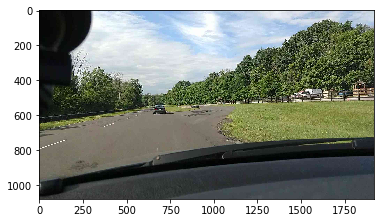

Shape:  (1080, 1920, 3)


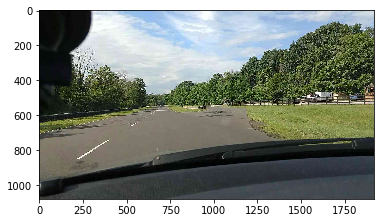

In [83]:
for idx in [0, 2762]:
    img = imread(train_df['img_path'][idx])
    print('Shape: ', img.shape)
    plt.imshow(img);
    plt.show();

In [177]:
img1 = imread(train_df['img_path'][0])
img1 = image_crop(400, 760, 250, 1920, img1)
img2 = imread(train_df['img_path'][2762])
img2 = image_crop(400, 760, 250, 1920, img2)
print(dhash(img1))
print(dhash(img2))
print(compare_dhash(img1, img2))
print(compare_phash(img1, img2))

375177039564486845129600453906583440632807036070413901274276213903224981027685977553749890284331821243724976062527
538706312398239033461152264796470670642382725036516946446030053600620587378201501696743442236935556396792517197887
0.8508771929824561
10.0


In [66]:
img1 = imread(train_df['img_path'][0])
img1 = image_crop(400, 760, 250, 1920, img1)
img2 = imread(train_df['img_path'][2762])
img2 = image_crop(400, 760, 250, 1920, img2)
print(compare_mse(img1, img2))
print(compare_nrmse(img1, img2))

1101.923214127301
0.42282000471767733


In [67]:
img1 = imread(train_df['img_path'][0])
img1 = image_crop(400, 760, 250, 1920, img1)
img2 = imread(train_df['img_path'][2762])
img2 = image_crop(400, 760, 250, 1920, img2)
print(compare_mse(img2, img1))
print(compare_nrmse(img2, img1))

1101.923214127301
0.42221023908308053


In [34]:
float_type = np.result_type(img1.dtype, img2.dtype, np.float32)

In [35]:
im1 = np.asarray(img1, dtype=float_type)
im2 = np.asarray(img2, dtype=float_type)

In [32]:
img1.shape

(360, 1670, 3)

In [53]:
np.mean(np.square(im1 - im2), dtype=np.float64)

1101.923214127301

In [43]:
np.mean(np.square(img1 - img2))

68.87989631847417

# Lap Time

In [13]:
def lap_time(initial_idx, sample, sample_frac, fps, topn, df, method, ascending, h1, h2, l1, l2, seed):
    np.random.seed(seed)
    results_dict = {}
    prior = initial_idx + np.floor(prior_time * fps).astype(int)
    img_idxs = np.random.choice(np.arange(initial_idx, np.floor(initial_idx+fps).astype(int)), np.round(sample*sample_frac).astype(int), replace=False).tolist() + np.random.choice(np.arange(np.ceil(initial_idx+fps).astype(int), np.floor(initial_idx+2*fps).astype(int)), np.round(sample*(1-sample_frac)).astype(int), replace=False).tolist()
    
    for idx in img_idxs:
        img = imread(df['img_path'][idx])
        similar_imgs = get_similar_image(img, df, method, ascending, prior, h1, h2, l1, l2)
        results_dict[idx] = [df['img_path'][idx], idx, (similar_imgs['img_index'].iloc[0]-idx)/fps, (weighted_index(similar_imgs, topn, method, ascending)-idx)/fps]
    
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    results_df.columns = ['img_path', 'img_index', 'lap_time', 'weighted_lap_time']
    return results_df

In [14]:
def lap_time2(initial_idx, end, fps, topn, df, method, ascending, coords):
    results_dict = {}
    start = initial_idx + np.round(fps*prior_time).astype(int)
    
    img_idxs = np.arange(initial_idx, initial_idx+5).tolist()
    #img_idxs = np.arange(initial_idx+5, initial_idx+10).tolist()
    #img_idxs = np.arange(initial_idx+10, initial_idx+15).tolist()
    #img_idxs = np.arange(initial_idx+15, initial_idx+20).tolist()
    #img_idxs = np.arange(initial_idx+20, initial_idx+25).tolist()
    #img_idxs = np.arange(initial_idx+25, np.round(initial_idx+fps).astype(int)).tolist()
    
    #img_idxs = np.arange(initial_idx, initial_idx+10).tolist()
    #img_idxs = np.arange(initial_idx+10, initial_idx+20).tolist()
    #img_idxs = np.arange(initial_idx+20, np.round(initial_idx+fps).astype(int)).tolist()
    
    #img_idxs = np.choice(np.arange(initial_idx, np.round(initial_idx+fps).astype(int)), 10).tolist()
    
    #img_idxs = np.arange(initial_idx, np.round(initial_idx+fps).astype(int)).tolist()
    
    for idx in img_idxs:
        img = imread(df['img_path'][idx])
        start_time = time.time()
        similar_imgs = get_similar_image(img, df, method, ascending, start, end, coords)
        elapsedTime = time.time() - start_time
        results_dict[idx] = [df['img_path'][idx], df['img_index'][idx], 
                             (np.mean(similar_imgs.img_index[similar_imgs[method]==(similar_imgs[method].iloc[0])])-df['img_index'][idx])/fps, 
                             (weighted_index(similar_imgs, topn, method, ascending)-df['img_index'][idx])/fps, 
                             elapsedTime, method]
    
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    results_df.columns = ['img_path', 'img_index', 'lap_time', 'weighted_lap_time', 'elapsedTime', 'method']
    return results_df

In [58]:
def lap_time2(initial_idx, end, fps, topn, df, method, ascending, coords):
    results_dict = {}
    start = initial_idx + np.round(fps*prior_time).astype(int)
    
    img_idxs = np.arange(initial_idx, initial_idx+3).tolist()
    #img_idxs = np.arange(initial_idx+3, initial_idx+6).tolist()
    #img_idxs = np.arange(initial_idx+6, initial_idx+9).tolist()
    #img_idxs = np.arange(initial_idx+9, initial_idx+12).tolist()
    #img_idxs = np.arange(initial_idx+12, initial_idx+15).tolist()
    #img_idxs = np.arange(initial_idx+15, initial_idx+18).tolist()
    #img_idxs = np.arange(initial_idx+18, initial_idx+21).tolist()
    #img_idxs = np.arange(initial_idx+21, initial_idx+24).tolist()
    #img_idxs = np.arange(initial_idx+24, initial_idx+27).tolist()
    #img_idxs = np.arange(initial_idx+27, np.round(initial_idx+fps).astype(int)).tolist()
    
    #img_idxs = np.arange(initial_idx, initial_idx+5).tolist()
    #img_idxs = np.arange(initial_idx+5, initial_idx+10).tolist()
    #img_idxs = np.arange(initial_idx+10, initial_idx+15).tolist()
    #img_idxs = np.arange(initial_idx+15, initial_idx+20).tolist()
    #img_idxs = np.arange(initial_idx+20, initial_idx+25).tolist()
    #img_idxs = np.arange(initial_idx+25, np.round(initial_idx+fps).astype(int)).tolist()
    
    #img_idxs = np.arange(initial_idx, initial_idx+10).tolist()
    #img_idxs = np.arange(initial_idx+10, initial_idx+20).tolist()
    #img_idxs = np.arange(initial_idx+20, np.round(initial_idx+fps).astype(int)).tolist()
    
    #img_idxs = np.choice(np.arange(initial_idx, np.round(initial_idx+fps).astype(int)), 10).tolist()
    
    for idx in img_idxs:
        #img = imread(df['img_path'][idx])
        start_time = time.time()
        similar_imgs = get_similar_image(df, method, ascending, idx, start, end, coords)
        elapsedTime = time.time() - start_time
        results_dict[idx] = [df['img_path'][idx], df['img_index'][idx], 
                             (np.mean(similar_imgs.img_index[similar_imgs[method]==(similar_imgs[method].iloc[0])])-df['img_index'][idx])/fps, 
                             (weighted_index(similar_imgs, topn, method, ascending)-df['img_index'][idx])/fps, 
                             elapsedTime, method]
    
    results_df = pd.DataFrame.from_dict(results_dict, orient='index')
    results_df.columns = ['img_path', 'img_index', 'lap_time', 'weighted_lap_time', 'elapsedTime', 'method']
    return results_df

In [244]:
def laps(initial_idx, end, fps, topn, df, method, ascending, h1, h2, l1, l2, maxlap=100000):
    lap_time = pd.DataFrame()
    start = initial_idx + np.round(fps*prior_time).astype(int)
    lap = 1
    
    while start < df.shape[0] and lap <= maxlap:
        temp = lap_time2(initial_idx, end, fps, topn, df, method, ascending, h1, h2, l1, l2)
        temp['lap'] = lap
        lap_time = lap_time.append(temp)
        lap += 1
        initial_idx += int(temp['lap_time'].iloc[0] * fps)
        start = initial_idx + np.round(fps*prior_time).astype(int)
        estimated_time = np.mean(temp['lap_time'])
        end = int(start + estimated_time * fps)
    if maxlap == 100000:
        return lap_time
    else:
        return (lap_time, initial_idx, end)

In [224]:
train_df = pd.read_csv(os.path.join(data_path, 'train153240_raw.csv'))
train_df.shape

(29759, 2)

In [215]:
prior_time = 60
threshold = 70

In [245]:
df = pd.read_csv(os.path.join(data_path, 'train153240_raw.csv'))

initial_idx = 6447
end = 11328

fps = 29.93943500598125
topn = 5
maxlap = 2

method = 'dHash'
ascending = True

h1 = 400
h2 = 760
l1 = 250
l2 = 1920

In [ ]:
temp, initial_idx, end = laps(initial_idx, end, fps, topn, df, method, ascending, h1, h2, l1, l2, maxlap)
temp.to_csv(os.path.join(result_path, '153240', 'lap34_dHash.csv'), index=False)

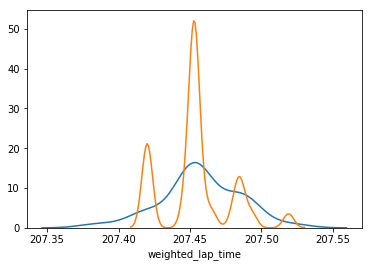

In [200]:
sns.distplot(test.lap_time, hist=False, norm_hist=True);
sns.distplot(test.weighted_lap_time, hist=False, norm_hist=True);

In [18]:
t = pd.read_csv('./result/video1crop_.csv')
t

Video      MSE      ORB    pHash    MSE_    ORB_  pHash_
0  92.22  92.1909  92.0751  92.2310 -0.0291 -0.1449  0.0110
1  92.11  92.1909  92.2043  92.1976  0.0809  0.0943  0.0876
2  90.76  90.8137  90.7781  90.8304  0.0537  0.0181  0.0704
3  90.05  90.0744  89.9553  89.0356  0.0244 -0.0947 -1.0144
4  89.67  89.6814  89.7883  89.6925  0.0114  0.1183  0.0225
5  89.89  89.8350  89.8595  89.9686 -0.0550 -0.0305  0.0786
6  89.12  89.1370  89.0635  89.2015  0.0170 -0.0565  0.0815
7  90.07  90.0755  90.1512  89.1637  0.0055  0.0812 -0.9063
8  89.57  89.5500  89.4843  89.7771 -0.0200 -0.0857  0.2071

In [19]:
temp = pd.DataFrame()
files = os.listdir('./result/091108/all1')
for file in files:
    if re.search('.csv', file) is not None:
        temp = temp.append(pd.read_csv(os.path.join('./result/091108/all1', file)))

In [20]:
temp.head(10)

img_path  img_index   lap_time  \
0  /home/idies/workspace/Storage/Cong/persistent/...       3466  92.052908   
1  /home/idies/workspace/Storage/Cong/persistent/...       3467  92.119710   
2  /home/idies/workspace/Storage/Cong/persistent/...       3468  92.052908   
3  /home/idies/workspace/Storage/Cong/persistent/...       3469  92.119710   
4  /home/idies/workspace/Storage/Cong/persistent/...       3470  92.086309   
5  /home/idies/workspace/Storage/Cong/persistent/...       3471  92.119710   
6  /home/idies/workspace/Storage/Cong/persistent/...       3472  92.086309   
7  /home/idies/workspace/Storage/Cong/persistent/...       3473  92.052908   
8  /home/idies/workspace/Storage/Cong/persistent/...       3474  92.052908   
9  /home/idies/workspace/Storage/Cong/persistent/...       3475  92.086309   

   weighted_lap_time  elapsedTime method  lap  
0          92.086148   411.219882    ORB    1  
1          92.099206   353.940855    ORB    1  
2          92.119372   351.149065    ORB    1  
3          92.138883   350.733084    ORB    1  
4          92.086815   352.235254    ORB    1  
5          92.086644   350.283716    ORB    1  
6          92.112970   351.828512    ORB    1  
7          92.118837   353.256444    ORB    1  
8          92.092513   349.584609    ORB    1  
9          92.040555   349.674749    ORB    1

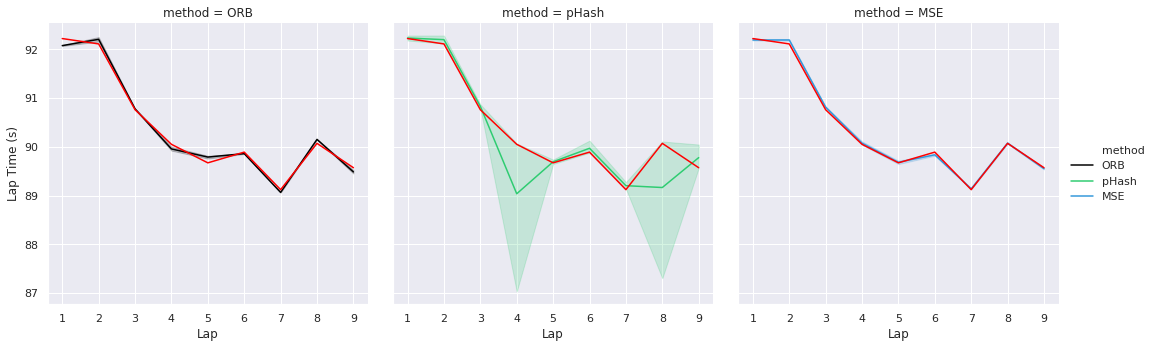

In [44]:
sns.set()
sns.set_palette(sns.color_palette(['#000000', '#2ecc71', '#3498db']))
ax = sns.relplot(x='lap', y='lap_time', hue='method', col='method', kind='line', data=temp);
ax.set_axis_labels('Lap', 'Lap Time (s)')
ax.axes[0][0].plot(np.arange(1,10), t.Video, color='red');
ax.axes[0][1].plot(np.arange(1,10), t.Video, color='red');
ax.axes[0][2].plot(np.arange(1,10), t.Video, color='red');

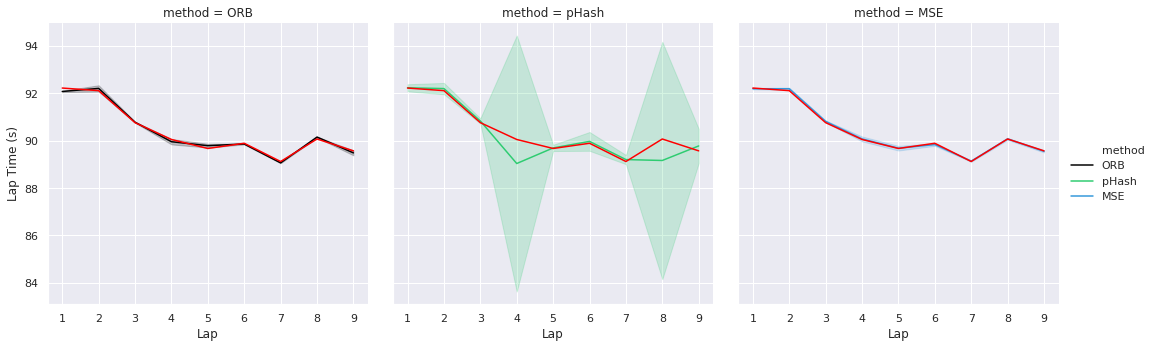

In [45]:
sns.set()
sns.set_palette(sns.color_palette(['#000000', '#2ecc71', '#3498db']))
ax = sns.relplot(x='lap', y='lap_time', hue='method', col='method', kind='line', ci='sd', data=temp);
ax.set_axis_labels('Lap', 'Lap Time (s)')
ax.axes[0][0].plot(np.arange(1,10), t.Video, color='red');
ax.axes[0][1].plot(np.arange(1,10), t.Video, color='red');
ax.axes[0][2].plot(np.arange(1,10), t.Video, color='red');

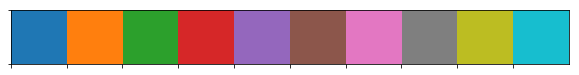

In [23]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

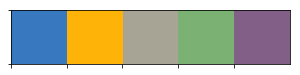

In [24]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.palplot(sns.xkcd_palette(colors))

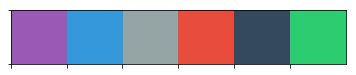

In [37]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.palplot(sns.color_palette(flatui))

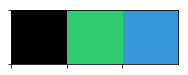

In [42]:
sns.palplot(sns.color_palette(['#000000', '#2ecc71', '#3498db']))

In [121]:
temp = pd.read_csv('./result/video1crop_.csv')
temp

Video      MSE      ORB    pHash    MSE_    ORB_  pHash_
0  92.1865  92.1909  92.0751  92.2310  0.0044 -0.1114  0.0445
1  92.1197  92.1909  92.2043  92.1976  0.0712  0.0846  0.0779
2  90.7502  90.8137  90.7781  90.8304  0.0635  0.0279  0.0802
3  90.0488  90.0744  89.9553  89.0356  0.0256 -0.0935 -1.0132
4  89.6814  89.6814  89.7883  89.6925  0.0000  0.1069  0.0111
5  89.9152  89.8350  89.8595  89.9686 -0.0802 -0.0557  0.0534
6  89.0802  89.1370  89.0635  89.2015  0.0568 -0.0167  0.1213
7  90.0822  90.0755  90.1512  89.1637 -0.0067  0.0690 -0.9185
8  89.5812  89.5500  89.4843  89.7771 -0.0312 -0.0969  0.1959

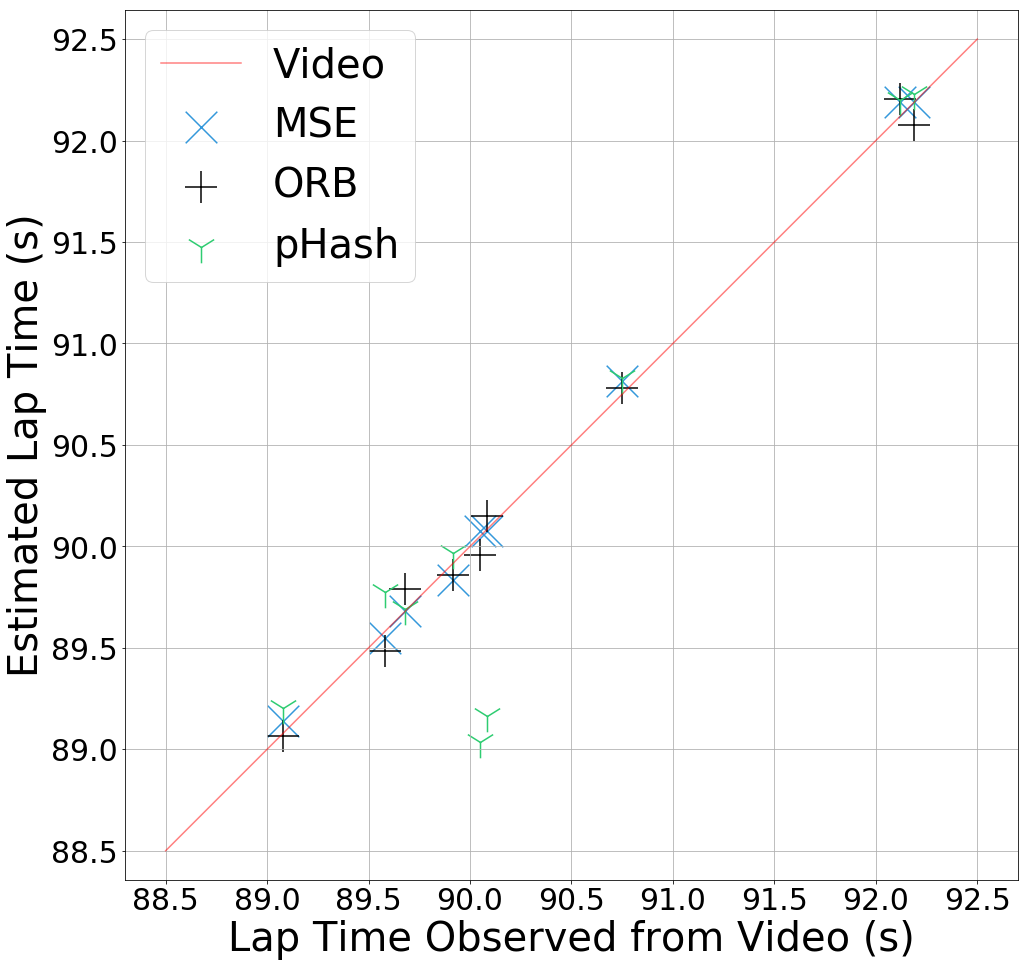

In [122]:
size = 1000
figure(figsize=(16,16));
rc('axes', labelsize=40);
rc('xtick', labelsize=30);
rc('ytick', labelsize=30);
axis('equal');
plot(np.linspace(88.5, 92.5, 100), np.linspace(88.5, 92.5, 100), 'r-', alpha=0.5, label='Video');
#scatter(temp.Video, temp.MSE, c='#3498db', marker='x', s=np.abs(temp.MSE_)*5000);
#scatter(temp.Video, temp.ORB, c='#000000', marker='+', s=np.abs(temp.ORB_)*5000);
#scatter(temp.Video, temp.pHash, c='#2ecc71', marker='1', s=np.abs(temp.pHash_)*5000);
scatter(temp.Video, temp.MSE, c='#3498db', marker='x', s=size);
scatter(temp.Video, temp.ORB, c='#000000', marker='+', s=size);
scatter(temp.Video, temp.pHash, c='#2ecc71', marker='1', s=size);
xlabel('Lap Time Observed from Video (s)');
ylabel('Estimated Lap Time (s)');
#xlim([88.5,92.5]);
#ylim([88.5,92.5]);
#legend(fontsize=40, markerscale=1, loc='center left', bbox_to_anchor=(1,0.5));
legend(fontsize=40);
grid();

In [124]:
temp = pd.read_csv('./result/video1mask_.csv')
temp

Video      MSE      ORB    pHash    MSE_    ORB_  pHash_
0  92.1865  92.1787  92.1380  92.2163 -0.0078 -0.0485  0.0298
1  92.1197  92.2187  92.2377  92.2527  0.0990  0.1180  0.1330
2  90.7502  90.8360  90.7792  90.8529  0.0858  0.0290  0.1027
3  90.0488  89.9976  89.9219  90.1552 -0.0512 -0.1269  0.1064
4  89.6814  89.7616  89.7938  88.0518  0.0802  0.1124 -1.6296
5  89.9152  89.8863  89.8640  88.0503 -0.0289 -0.0512 -1.8649
6  89.0802  89.1303  89.0601  86.5769  0.0501 -0.0201 -2.5033
7  90.0822  90.0945  90.1624  90.0803  0.0123  0.0802 -0.0019
8  89.5812  89.5244  89.4420  89.5624 -0.0568 -0.1392 -0.0188

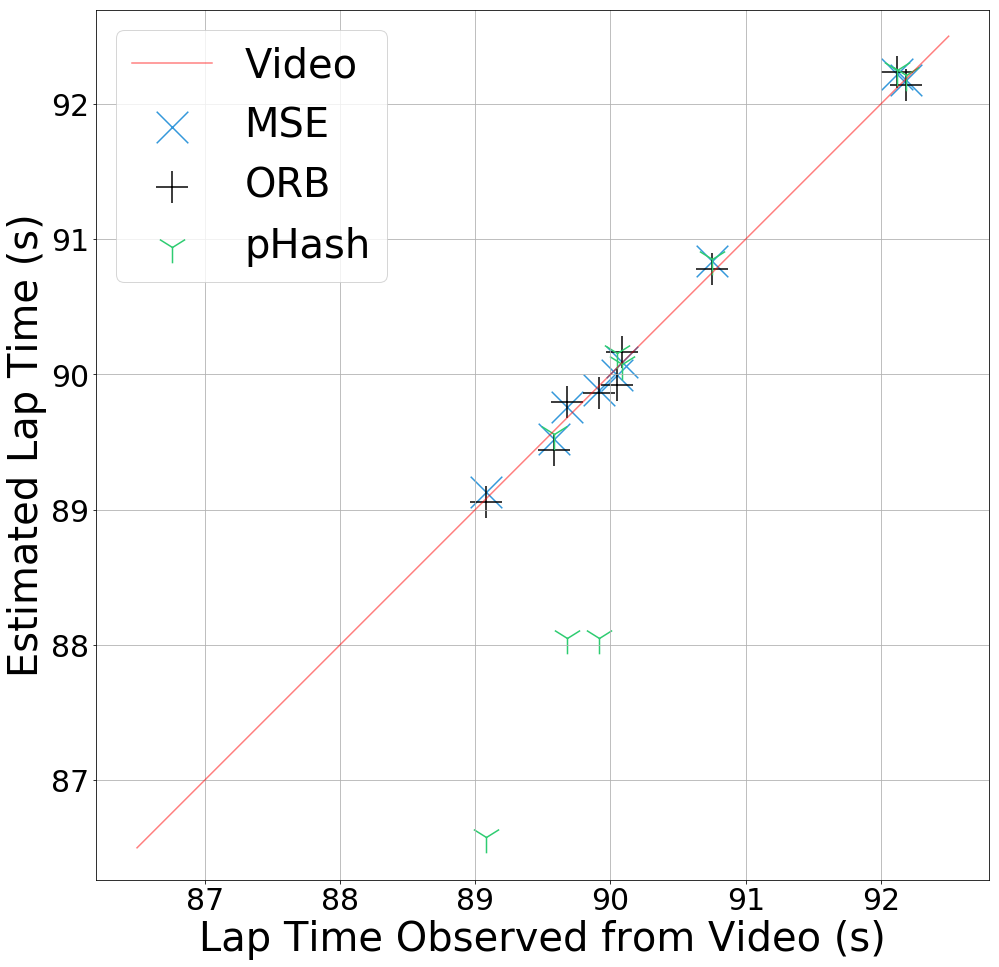

In [126]:
size = 1000
figure(figsize=(16,16));
rc('axes', labelsize=40);
rc('xtick', labelsize=30);
rc('ytick', labelsize=30);
axis('equal');
plot(np.linspace(86.5, 92.5, 100), np.linspace(86.5, 92.5, 100), 'r-', alpha=0.5, label='Video');
#scatter(temp.Video, temp.MSE, c='#3498db', marker='x', s=np.abs(temp.MSE_)*5000);
#scatter(temp.Video, temp.ORB, c='#000000', marker='+', s=np.abs(temp.ORB_)*5000);
#scatter(temp.Video, temp.pHash, c='#2ecc71', marker='1', s=np.abs(temp.pHash_)*5000);
scatter(temp.Video, temp.MSE, c='#3498db', marker='x', s=size);
scatter(temp.Video, temp.ORB, c='#000000', marker='+', s=size);
scatter(temp.Video, temp.pHash, c='#2ecc71', marker='1', s=size);
xlabel('Lap Time Observed from Video (s)');
ylabel('Estimated Lap Time (s)');
#xlim([88.5,92.5]);
#ylim([88.5,92.5]);
#legend(fontsize=40, markerscale=1, loc='center left', bbox_to_anchor=(1,0.5));
legend(fontsize=40);
grid();

In [4]:
temp = pd.read_csv('./result/video1maskall_.csv')
temp

Video      MSE      ORB    pHash    MSE_    ORB_  pHash_
0  92.1865  92.1865  92.1197  92.1238  0.0000 -0.0668 -0.0627
1  92.1197  92.2199  92.2533  92.2533  0.1002  0.1336  0.1336
2  90.7502  90.8504  90.7836  90.8337  0.1002  0.0334  0.0835
3  90.0488  89.9820  89.9152  90.0154 -0.0668 -0.1336 -0.0334
4  89.6814  89.7816  89.8150  89.7315  0.1002  0.1336  0.0501
5  89.9152  89.8818  89.8484  89.9152 -0.0334 -0.0668  0.0000
6  89.0802  89.1136  89.0802  89.1136  0.0334  0.0000  0.0334
7  90.0822  90.0989  90.1490  90.0822  0.0167  0.0668  0.0000
8  89.5812  89.5144  89.4476  89.5422 -0.0668 -0.1336 -0.0390

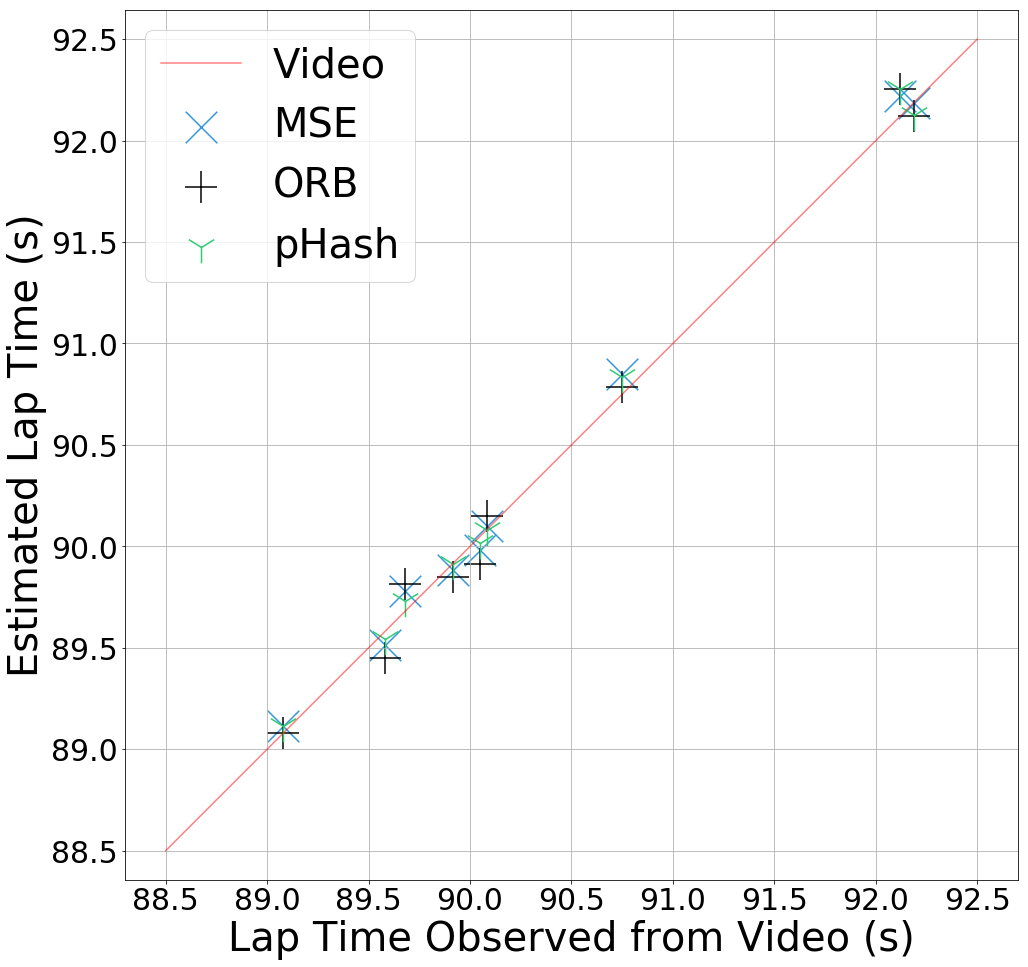

In [6]:
size = 1000
figure(figsize=(16,16));
rc('axes', labelsize=40);
rc('xtick', labelsize=30);
rc('ytick', labelsize=30);
axis('equal');
plot(np.linspace(88.5, 92.5, 100), np.linspace(88.5, 92.5, 100), 'r-', alpha=0.5, label='Video');
#scatter(temp.Video, temp.MSE, c='#3498db', marker='x', s=np.abs(temp.MSE_)*5000);
#scatter(temp.Video, temp.ORB, c='#000000', marker='+', s=np.abs(temp.ORB_)*5000);
#scatter(temp.Video, temp.pHash, c='#2ecc71', marker='1', s=np.abs(temp.pHash_)*5000);
scatter(temp.Video, temp.MSE, c='#3498db', marker='x', s=size);
scatter(temp.Video, temp.ORB, c='#000000', marker='+', s=size);
scatter(temp.Video, temp.pHash, c='#2ecc71', marker='1', s=size);
xlabel('Lap Time Observed from Video (s)');
ylabel('Estimated Lap Time (s)');
#xlim([88.5,92.5]);
#ylim([88.5,92.5]);
#legend(fontsize=40, markerscale=1, loc='center left', bbox_to_anchor=(1,0.5));
legend(fontsize=40);
grid();